In [1]:
# Setting up of data (training and test sets, preprocessing)
import os
import pandas as pd
import random
from sklearn.feature_selection import RFE
from sklearn.utils import shuffle
from sklearn import cross_validation, grid_search, metrics, ensemble
import sklearn.linear_model as lr
from sklearn.preprocessing import scale
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV
from sklearn import cross_validation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from statistics import mean
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.grid_search import GridSearchCV
import lightgbm as lgb

cwd = os.getcwd()
print(cwd)
os.chdir("C:\\Users\\User\Documents")

data = pd.read_csv('vipdatamodelling6.csv',encoding='windows-1254')
#data["sec_source"] = data["sec_source"].astype('category') # convert sec_source, order_source into categorical features
#data["order_source"] = data["order_source"].astype('category')
#data["sec_source_cat"] = data["sec_source"].cat.codes
#data["order_source_cat"] = data["order_source"].cat.codes

print('Done cleaning!')
data1 = shuffle(data)
df = data1.iloc[:6988] # 70% as training dataset, 30% as testing dataset
dftest = data1.iloc[6989:]
target = df.pop('target2') # extracting the labels for training dataset
# cross validation by creating pseudo testing and training dataset
train_data, test_data, train_labels, test_labels = cross_validation.train_test_split(df, target, test_size = 0.3, random_state=1)
actual_test_labels = dftest.pop('target2') 
actual_test_data = dftest # extracting the labels for testing dataset
print('Done splitting!')

C:\Users\User\Anaconda3\envs\newenvt\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\User\Anaconda3\envs\newenvt\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


C:\Users\User
Done cleaning!
Done splitting!


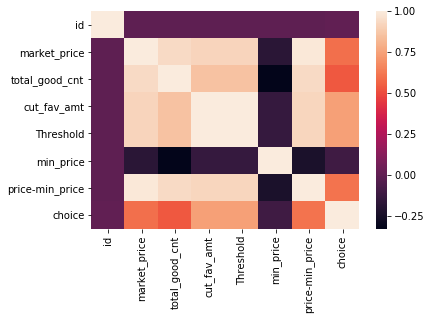

C:\Users\User\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


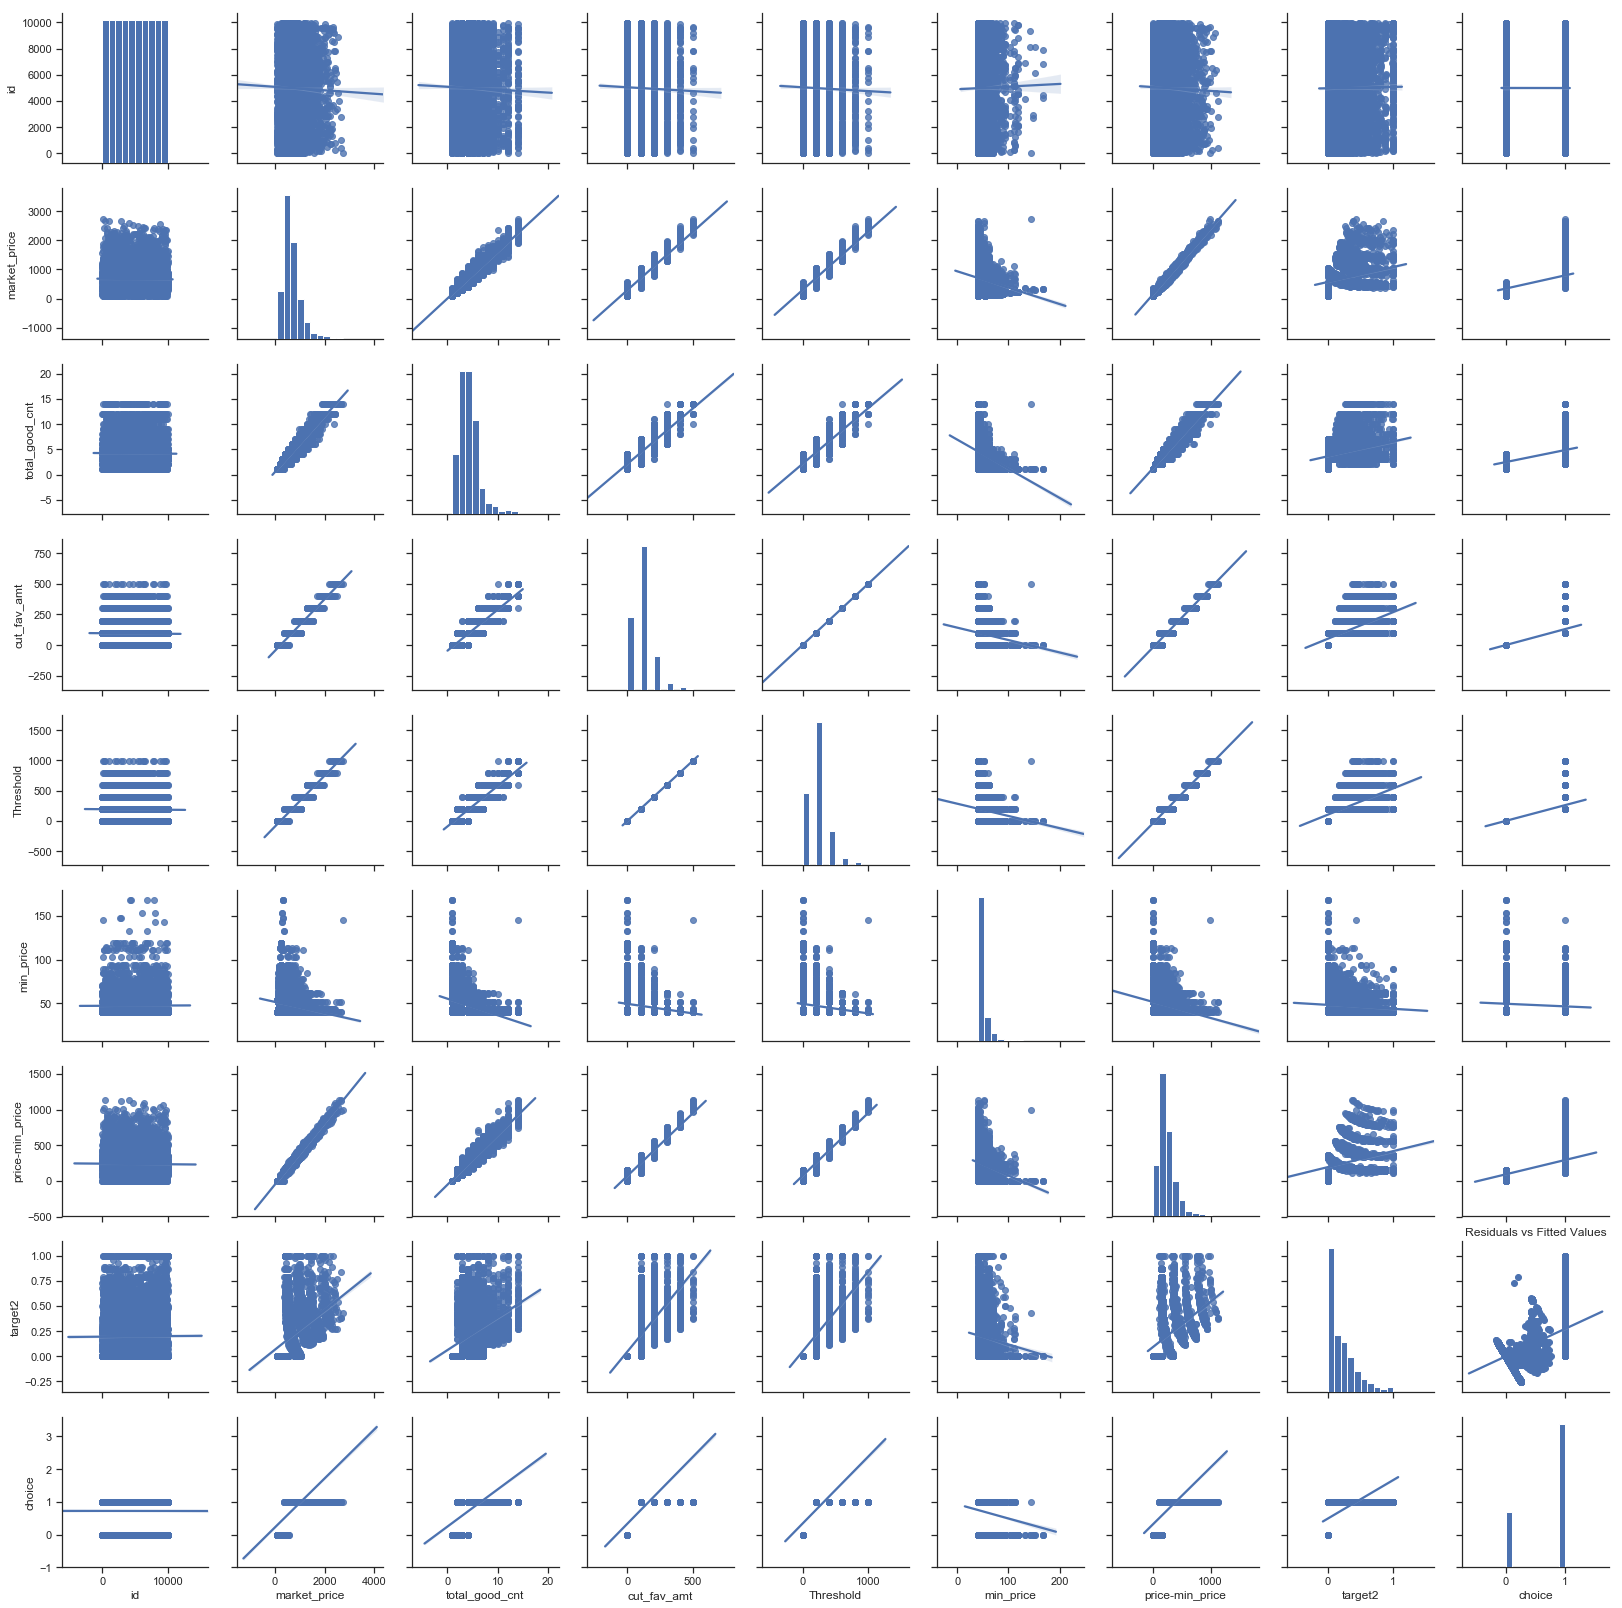

In [2]:
# Checking for regression assumptions
# regression is invalid as violation of multicollinearity
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

sns.heatmap(train_data.corr())
plt.show()
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(data, kind="reg") 

#y_box = stats.boxcox(train_labels+0.000000000000001, alpha=0.01)
model = lr.LinearRegression()
#model.fit(train_data, y_box[0]) 
model.fit(train_data, train_labels) 
fitted_values = model.predict(train_data)
#resid = y_box[0] - fitted_values
resid = train_labels - fitted_values
plt.scatter(fitted_values, resid)
plt.title('Residuals vs Fitted Values')
plt.show()

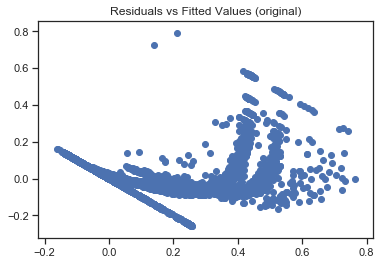

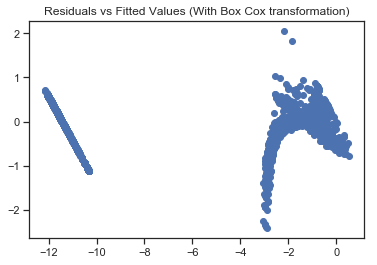

In [3]:
# Checking for regression assumptions
# regression is invalid as violation of multicollinearity

#y_box = stats.boxcox(train_labels+0.000000000000001, alpha=0.01)
model = lr.LinearRegression()
#model.fit(train_data, y_box[0]) 
model.fit(train_data, train_labels) 
fitted_values = model.predict(train_data)
#resid = y_box[0] - fitted_values
resid = train_labels - fitted_values
plt.scatter(fitted_values, resid)
plt.title('Residuals vs Fitted Values (original)')
plt.show()

y_box = stats.boxcox(train_labels+0.000000000000001, alpha=0.01)
model = lr.LinearRegression()
model.fit(train_data, y_box[0]) 
fitted_values = model.predict(train_data)
resid = y_box[0] - fitted_values
plt.scatter(fitted_values, resid)
plt.title('Residuals vs Fitted Values (With Box Cox transformation)')
plt.show()

{'boosting_type': 'gbdt', 'colsample_bytree': 0.65, 'learning_rate': 0.07, 'max_depth': 7, 'n_estimators': 50, 'num_leaves': 12, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 1}
Fitting with params: 
{'boosting_type': 'gbdt', 'max_depth': -1, 'nthread': 3, 'num_leaves': 12, 'learning_rate': 0.07, 'max_bin': 512, 'subsample_for_bin': 200, 'subsample': 1, 'subsample_freq': 1, 'colsample_bytree': 0.65, 'reg_alpha': 1, 'reg_lambda': 1, 'min_split_gain': 0.5, 'min_child_weight': 1, 'min_child_samples': 5, 'scale_pos_weight': 1, 'num_class': 1, 'metric': 'l2'}
Training until validation scores don't improve for 25 rounds.
[4]	valid_0's l2: 0.030569	valid_1's l2: 0.0297263
[8]	valid_0's l2: 0.0208627	valid_1's l2: 0.020121
[12]	valid_0's l2: 0.0172232	valid_1's l2: 0.0165036
[16]	valid_0's l2: 0.0149703	valid_1's l2: 0.0142484
[20]	valid_0's l2: 0.0124758	valid_1's l2: 0.0117738
[24]	valid_0's l2: 0.0107735	valid_1's l2: 0.0101068
[28]	valid_0's l2: 0.00972637	valid_1's l2: 0.00908533
[32]	val

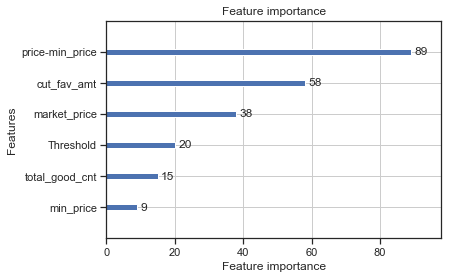

(Pseudo Test) MSE =  0.008360543793964831
(Pseudo Test) MAE =  0.05172094062870626
(Test) MSE =  0.007778622310489429
(Test) MAE =  0.050512301388994034


In [16]:
# Model 6: Boosted Regression Tree (with Light GBM) 
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_curve, auc, accuracy_score)
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

# Set params
# Scores ~0.784 (without tuning and early stopping)
params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'nthread': 3, # Updated from nthread
          'num_leaves': 64,
          'learning_rate': 0.05,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 5,
          'reg_lambda': 10,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'l2'}

# Create parameters to search
gridParams = {
    'learning_rate': [0.001, 0.005, 0.01,0.03, 0.05, 0.07, 0.1],
    'max_depth' : [1,3,5,7],
    'n_estimators': [40,50,100],
    'num_leaves': [6,8,12,16],
    'boosting_type' : ['gbdt'],
    'colsample_bytree' : [0.65, 0.66],
    'subsample' : [0.65,0.7,0.75,0.8,1],
    'reg_alpha' : [1,1.2],
    'reg_lambda' : [1,1.2,1.4],
    }
# Create regressor to use. Note that parameters have to be input manually
# not as a dict!
mdl = lgb.LGBMRegressor(boosting_type= 'gbdt',
          n_jobs = 3, # Updated from 'nthread'
          silent = True,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'],
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'],
          subsample_freq = params['subsample_freq'],
          min_split_gain = params['min_split_gain'],
          min_child_weight = params['min_child_weight'],
          min_child_samples = params['min_child_samples'],
          scale_pos_weight = params['scale_pos_weight'])



# To view the default model params:
mdl.get_params().keys()

# Create the grid
grid = GridSearchCV(mdl, gridParams,
                    scoring='neg_mean_squared_error',
                    verbose=0,
                    cv=10,
                    n_jobs=2)
# Run the grid
grid.fit(train_data, train_labels)

# Print the best parameters found
print(grid.best_params_)

# Using parameters already set above, replace in the best from the grid search
params['colsample_bytree'] = grid.best_params_['colsample_bytree']
params['learning_rate'] = grid.best_params_['learning_rate']
# params['max_bin'] = grid.best_params_['max_bin']
params['num_leaves'] = grid.best_params_['num_leaves']
params['reg_alpha'] = grid.best_params_['reg_alpha']
params['reg_lambda'] = grid.best_params_['reg_lambda']
params['subsample'] = grid.best_params_['subsample']
# params['subsample_for_bin'] = grid.best_params_['subsample_for_bin']

print('Fitting with params: ')
print(params)

    # Train optimal model 
gbm = lgb.train(params,
                lgb.Dataset(train_data, label = train_labels),
                valid_sets = [lgb.Dataset(test_data,label = test_labels),lgb.Dataset(actual_test_data,label = actual_test_labels)],
                early_stopping_rounds = 25,
                verbose_eval = 4)
      # Plot importance
lgb.plot_importance(gbm)  # Figure 7.8
plt.show() 


    # Predict
pred = gbm.predict(test_data,num_iteration=gbm.best_iteration)
actual_pred = gbm.predict(actual_test_data,num_iteration=gbm.best_iteration)
print("(Pseudo Test) MSE = ",mean_squared_error(test_labels, pred)) # Results on Table 7.7
print("(Pseudo Test) MAE = ",mean_absolute_error(test_labels, pred))  # Results on Table 7.7
print("(Test) MSE = ",mean_squared_error(actual_test_labels, actual_pred))  # Results on Table 7.7
print("(Test) MAE = ",mean_absolute_error(actual_test_labels, actual_pred)) # Results on Table 7.7


 K Nearest Neighbors
Parameters
{'n_neighbors': 1}

CV Validation Score
[0.91970835 0.91722956 0.92095277 0.91051674 0.92942785 0.95817885
 0.89455966 0.94678439 0.91879493 0.88762159]

Mean Validation Score
0.9203773322992577
[0.9203773322992577, 0.9397632404611564, 0.9429855745385579, 0.9447533127863224, 0.9418293105236598, 0.9398283072834824, 0.9378223483294768, 0.9361411661491663, 0.9338970507283519, 0.9327499884582997, 0.9318286943199531, 0.9301111463669328, 0.9287178151246773, 0.9270118627126837, 0.9254486482828956, 0.9242865927130549, 0.9227869434952027, 0.9214611624883875, 0.9198425922922553, 0.9181316665438869, 0.9166615698611125, 0.9152886474550956, 0.9143529662365341, 0.9127829664709349, 0.9115350663187124, 0.9102875198470106, 0.9089955231511537, 0.9078290927076009, 0.9065272619046822, 0.9056691408060145, 0.9041325663862918, 0.9027509472278524, 0.9014435330219679, 0.9001265602523595, 0.8987586901499696, 0.8977484454814517, 0.8962991432328673, 0.8953219232313816, 0.894370423

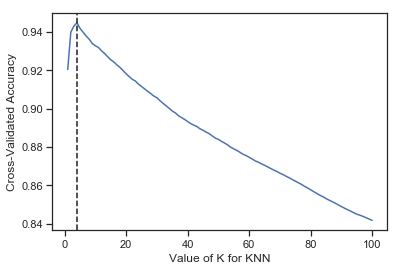

In [5]:
# Model 7: KNN 
# K Nearest Neighbors Regression
print('\n','K Nearest Neighbors')
from sklearn.preprocessing import MinMaxScaler
from sklearn import neighbors
from math import sqrt
import matplotlib.pyplot as plt
knn = neighbors.KNeighborsRegressor()
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.fit_transform(test_data)
actual_test_data_scaled = scaler.fit_transform(actual_test_data)

k_range = list(range(1, 101))
param_grid = dict(n_neighbors=k_range)
grid = GridSearchCV(knn, param_grid, cv=10)
grid.fit(train_data_scaled,train_labels)
grid.grid_scores_
print('Parameters')
print(grid.grid_scores_[0].parameters) # Figure 7.9

# Array of 10 accuracy scores during 10-fold cv using the parameters
print('')
print('CV Validation Score')
print(grid.grid_scores_[0].cv_validation_scores)

# Mean of the 10 scores
print('')
print('Mean Validation Score')
print(grid.grid_scores_[0].mean_validation_score)
grid_mean_scores = [result.mean_validation_score for result in grid.grid_scores_]
print(grid_mean_scores)

plt.plot(k_range, grid_mean_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.axvline(x=4, color='k', linestyle='--')
print(grid.best_score_)

# Dictionary containing the parameters (k) used to generate that score
print(grid.best_params_)

# Actual model object fit with those best parameters
# Shows default parameters that we did not specify
print(grid.best_estimator_)


knn = neighbors.KNeighborsRegressor(n_neighbors=4) # since best param is k = 4
knn.fit(train_data_scaled,train_labels)
pred = knn.predict(test_data_scaled)
actual_pred = knn.predict(actual_test_data_scaled)
print("(Pseudo Test) MSE = ",mean_squared_error(test_labels, pred)) # Results on Table 7.8
print("(Pseudo Test) MAE = ",mean_absolute_error(test_labels, pred)) # Results on Table 7.8
print("(Test) MSE = ",mean_squared_error(actual_test_labels, actual_pred)) # Results on Table 7.8
print("(Test) MAE = ",mean_absolute_error(actual_test_labels, actual_pred)) # Results on Table 7.8

In [3]:
# Model 8: ANN
import numpy as np
from keras.layers import Dense, Activation
from keras.models import Sequential
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.fit_transform(test_data)
actual_test_data_scaled = scaler.fit_transform(actual_test_data)


# Initialising the ANN
model = Sequential()

# Adding the input layer and the first hidden layer
model.add(Dense(18, activation = 'relu', input_dim = 8))

# Adding the second hidden layer
model.add(Dense(units = 18, activation = 'relu'))

# Adding the third hidden layer
model.add(Dense(units = 18, activation = 'relu'))

# Adding the output layer

model.add(Dense(units = 1))

#model.add(Dense(1))
# Compiling the ANN
model.compile(optimizer = 'adam', loss = 'mean_squared_error') # Adam: adaptive moment estimation

# Fitting the ANN to the Training set
model.fit(train_data_scaled, train_labels, batch_size = 10, epochs = 100)


Epoch 1/100
4891/4891 [==============================] - 5s 1ms/step - loss: 0.0300
Epoch 2/100
4891/4891 [==============================] - 2s 331us/step - loss: 0.0148
Epoch 3/100
4891/4891 [==============================] - 2s 344us/step - loss: 0.0085
Epoch 4/100
4891/4891 [==============================] - 2s 343us/step - loss: 0.0068
Epoch 5/100
4891/4891 [==============================] - 2s 342us/step - loss: 0.0062
Epoch 6/100
4891/4891 [==============================] - 2s 341us/step - loss: 0.0053 0s - loss: 0
Epoch 7/100
4891/4891 [==============================] - 2s 371us/step - loss: 0.0051
Epoch 8/100
4891/4891 [==============================] - 2s 356us/step - loss: 0.0046
Epoch 9/100
4891/4891 [==============================] - 2s 349us/step - loss: 0.0042
Epoch 10/100
4891/4891 [==============================] - 2s 351us/step - loss: 0.0038 0s - loss:
Epoch 11/100
4891/4891 [==============================] - 2s 352us/step - loss: 0.0041
Epoch 12/100
4891/4891 [======

(Pseudo Test) MSE =  0.016073455392500727
(Pseudo Test) MAE =  0.07860336910392184
(Test) MSE =  0.007659616191909153
(Test) MAE =  0.04737428975849813
2995


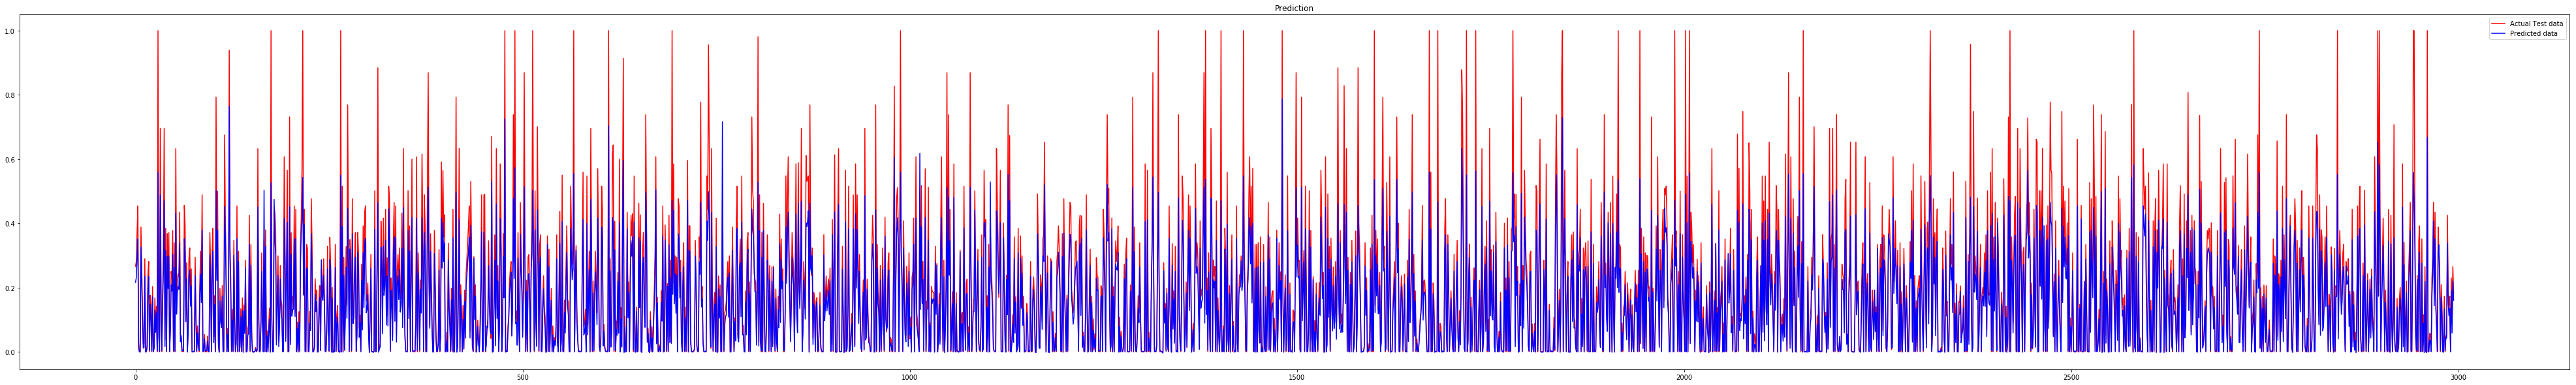

In [7]:
# Model 8: ANN
y_pred1 = model.predict(test_data_scaled)
y_pred2 = model.predict(actual_test_data_scaled)

print("(Pseudo Test) MSE = ",mean_squared_error(test_labels, y_pred1)) # Results on Table 7.9
print("(Pseudo Test) MAE = ",mean_absolute_error(test_labels, y_pred1)) # Results on Table 7.9
print("(Test) MSE = ",mean_squared_error(actual_test_labels, y_pred2)) # Results on Table 7.9
print("(Test) MAE = ",mean_absolute_error(actual_test_labels, y_pred2)) # Results on Table 7.9
print(len(y_pred2))
actual_test_labels.index = range(0,len(y_pred2))
plt.figure(figsize=(70,10))
plt.plot(actual_test_labels, color = 'red', label = 'Actual Test data')
plt.plot(y_pred2, color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show() # Figure 7.10

1      0.041848
2      0.200947
3      0.343036
4      0.200947
5      0.031492
6      0.013640
7      0.168101
8      0.343036
9      0.301188
10     0.021583
11     0.197443
12     0.168101
13     0.336570
14     0.168101
15     0.197443
16     0.336570
17     0.015206
18     0.235156
19     0.197443
20     0.031492
21     0.197443
22     0.235156
23     0.343036
24     0.197443
25     0.031492
26     0.747834
27     0.031492
28     0.197443
29     0.420267
30     0.235156
         ...   
363    0.013640
364    0.200947
365    0.168101
366    0.005962
367    0.197443
368    0.168101
369    0.252166
370    0.177471
371    0.235156
372    0.021583
373    0.197443
374    0.005962
375    0.013640
376    0.197443
377    0.168101
378    0.197443
379    0.168101
380    0.343036
381    0.200947
382    0.168101
383    0.200947
384    0.197443
385    0.343036
386    0.420267
387    0.200947
388    0.013640
389    0.000000
390    0.168101
391    0.235156
392    0.747834
Name: target2, Length: 3

In [7]:

# knn = neighbors.KNeighborsRegressor(n_neighbors=14) # since best param is k = 3 
# knn.fit(train_data_scaled,train_labels)
# pred = knn.predict(test_data_scaled)
# actual_pred = knn.predict(actual_test_data_scaled)
# print("(Pseudo Test) MSE = ",mean_squared_error(test_labels, pred))
# print("(Pseudo Test) MAE = ",mean_absolute_error(test_labels, pred))
# print("(Test) MSE = ",mean_squared_error(actual_test_labels, actual_pred))
# print("(Test) MAE = ",mean_absolute_error(actual_test_labels, actual_pred))

(Pseudo Test) MSE =  0.014515626857949337
(Pseudo Test) MAE =  0.0662180529566728
(Test) MSE =  0.011120621089742941
(Test) MAE =  0.06148669896305748


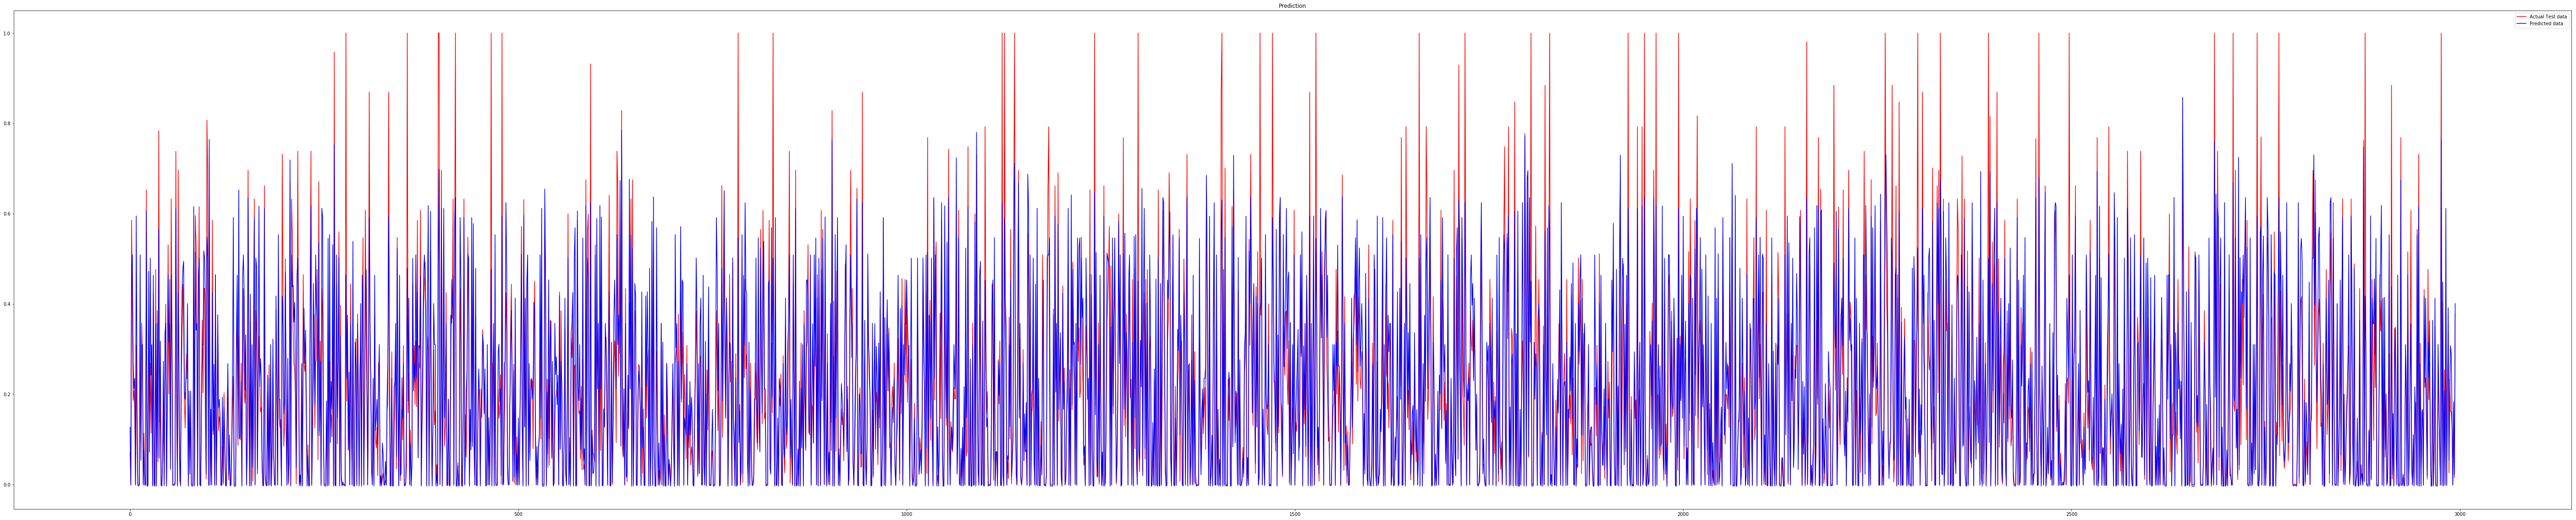

In [9]:
# plt.figure(figsize=(100,20))
# plt.plot(actual_test_labels, color = 'red', label = 'Actual Test data')
# plt.plot(y_pred2, color = 'blue', label = 'Predicted data')
# plt.title('Prediction')
# plt.legend()